# Estimate covariance matrix of financial time series (FTS)

In [1]:
import re
import sys
import warnings
import numpy as np # type: ignore
import pandas as pd # type: ignore

sys.path.append('../modules')
import misc_functions as mf # type: ignore
import estimate_entropy as ee # type: ignore
import get_financial_time_series as get_fts # type: ignore

warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
#pd.options.display.max_rows = 277

## Global variables

In [2]:
input_path_raw = "../input_files/raw_data"
input_path_processed = "../input_files/processed_data"
input_path_data_dictionary = "../input_files/data_dictionary"
log_path = "../logs"
output_path = "../output_files"
input_generation_date = "2024-06-24"

## Load data and filter duplicates by symbol and date

In [3]:
# Standard and Poor's 500 - S&P 500 (United States)
df_stock_index = pd.read_pickle("{}/df_sp500_{}.pkl".format(input_path_processed, re.sub("-", "", input_generation_date)))
df_stock_index.drop_duplicates(subset = ["date", "symbol"], keep = "first", inplace = True, ignore_index = True)

## Example for Mutual Information

In [4]:
x = [0.5, 0.5]
y = [0.1, 0.9]

joint_xx = [0.25, 0.25, 0.25, 0.25]
joint_xy = [0.05, 0.45, 0.05, 0.45]
joint_yx = [0.05, 0.05, 0.45, 0.45]
joint_yy = [0.01, 0.09, 0.09, 0.81]
joint_proof = [0.1, 0.2, 0.3, 0.4]

print("Shannon entropies: ")
print(mf.estimate_renyi_entropy(x = x, p = 1))
print(mf.estimate_renyi_entropy(x = y, p = 1))
print(mf.estimate_renyi_entropy(x = x, p = 1) + mf.estimate_renyi_entropy(x = y, p = 1))
print("\nMutual information: ")
print(mf.estimate_mutual_information(x = x, y = x, joint_xy = joint_xx))
print(mf.estimate_mutual_information(x = x, y = y, joint_xy = joint_xy))
print(mf.estimate_mutual_information(x = y, y = x, joint_xy = joint_yx))
print(mf.estimate_mutual_information(x = y, y = y, joint_xy = joint_yy))
print("\nVariance of information: ")
print(mf.estimate_shared_information_distance(x = x, y = x, joint_xy = joint_xx) / 2)
print(mf.estimate_shared_information_distance(x = x, y = y, joint_xy = joint_xy))
print(mf.estimate_shared_information_distance(x = y, y = x, joint_xy = joint_yx))
print(mf.estimate_shared_information_distance(x = y, y = y, joint_xy = joint_yy) / 2)
print("\nMutual information changing joint probability: ")
print(mf.estimate_mutual_information(x = x, y = x, joint_xy = joint_proof))
print(mf.estimate_mutual_information(x = x, y = y, joint_xy = joint_proof))
print(mf.estimate_mutual_information(x = y, y = x, joint_xy = joint_proof))
print(mf.estimate_mutual_information(x = y, y = y, joint_xy = joint_proof))
print("\nVariance of information changing joint probability: ")
print(mf.estimate_shared_information_distance(x = x, y = x, joint_xy = joint_proof))
print(mf.estimate_shared_information_distance(x = x, y = y, joint_xy = joint_proof))
print(mf.estimate_shared_information_distance(x = y, y = x, joint_xy = joint_proof))
print(mf.estimate_shared_information_distance(x = y, y = y, joint_xy = joint_proof))

Shannon entropies: 
0.6931471805599453
0.3250829733914482
1.0182301539513934

Mutual information: 
0
-2.220446049250313e-16
-2.220446049250313e-16
0

Variance of information: 
0.6931471805599453
1.0182301539513938
1.0182301539513938
0.3250829733914482

Mutual information changing joint probability: 
0
-0.2616240718822742
-0.2616240718822742
0

Variance of information changing joint probability: 
1.2798542258336676
1.5414782977159418
1.5414782977159418
1.2798542258336676


## Entropy matrix (proof)

In [5]:
ee.estimate_entropy_pairs(
    df = df_stock_index,
    precision = 12,
    normalized = True,
    log_path = log_path,
    log_filename = "log_entropy_proof",
    verbose = 1,
    entropy_args_list = ("MMM", "ZTS", 76, 50)
)


,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,modified_jaccard_distance
0,MMM,MMM,2.80137,2.391416,4.832951,0.000000,4.832951,1.000000
1,MMM,ZTS,2.80137,2.391416,4.832951,0.359834,4.473117,0.925546
2,ZTS,MMM,2.80137,2.391416,4.832951,0.359834,4.473117,0.925546
3,ZTS,ZTS,2.80137,2.391416,4.832951,0.000000,4.832951,1.000000


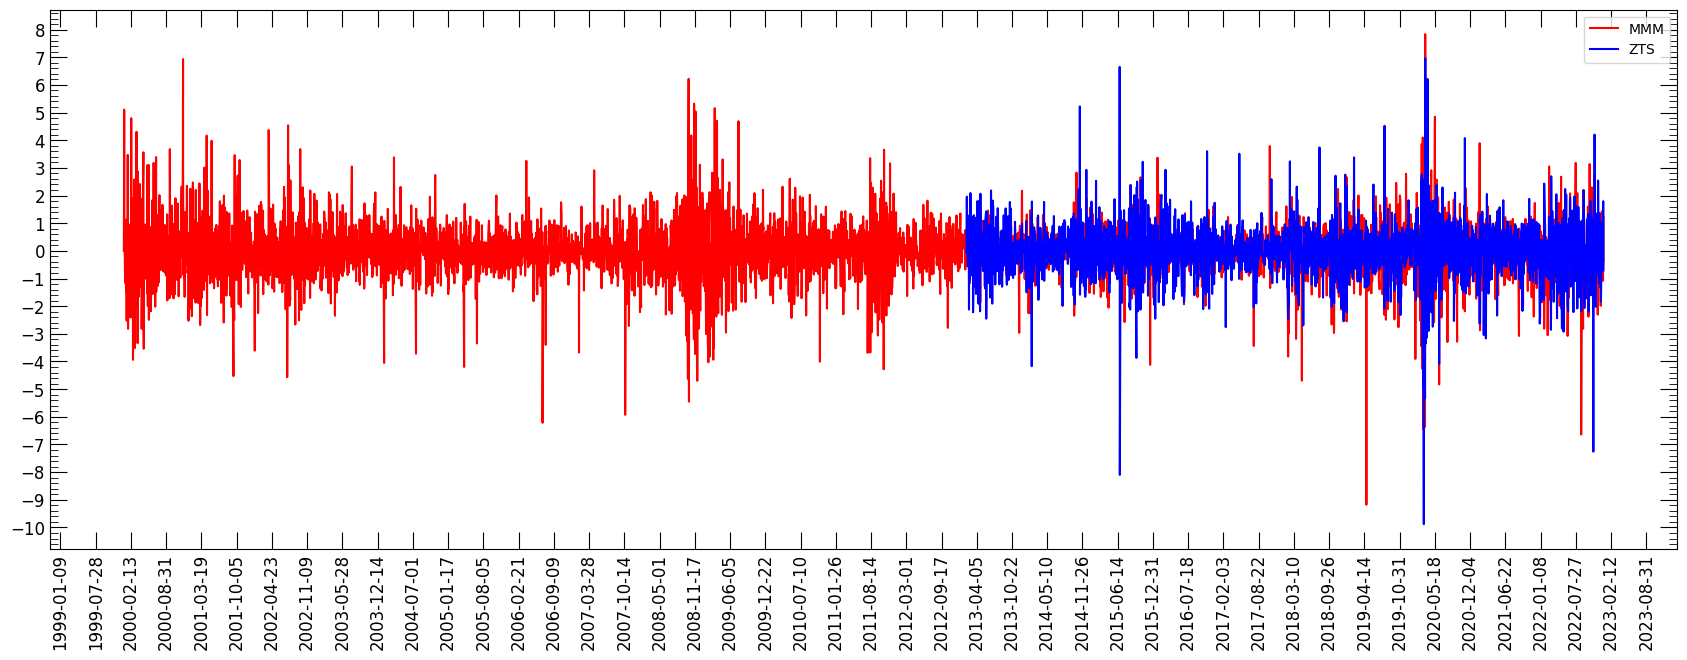

In [6]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

fig,ax = plt.subplots()
fig.set_size_inches(w = 21, h = 7)

df_1 = df_stock_index[df_stock_index["symbol"] == "MMM"]
df_2 = df_stock_index[df_stock_index["symbol"] == "ZTS"]

ax.plot(df_1["date"], df_1["normalized_log_return"], color = "red", label = "MMM")
ax.plot(df_2["date"], df_2["normalized_log_return"], color = "blue", label = "ZTS")

ax.tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax.tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax.xaxis.set_major_locator(mtick.MaxNLocator(60))
#ax.xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax.yaxis.set_major_locator(mtick.MaxNLocator(20))
ax.yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax.tick_params(axis = "x", labelrotation = 90)
ax.legend()
plt.show()


## Construct covariance matrix and compare with entropy matrix

In [7]:
df_cov = get_fts.estimate_covariance_stock_index(df = df_stock_index, normalized = True)
df_cov["symbol"] = df_cov.columns
df_cov.insert(0, "symbol", df_cov.pop("symbol"))
A = df_cov[df_cov["symbol"].str.contains("Z")]
A[A.symbol]

symbol,AIZ,AMZN,AZO,CZR,DPZ,IVZ,MDLZ,STZ,VZ,ZBH,ZBRA,ZTS
18,1.000000,0.234901,0.296099,0.321501,0.283679,0.538976,0.347923,0.316716,0.337403,0.365495,0.303348,0.297891
32,0.234901,1.000000,0.248411,0.216612,0.248761,0.331204,0.179530,0.170897,0.226443,0.216320,0.304520,0.256602
49,0.296099,0.248411,1.000000,0.258938,0.284751,0.361302,0.278995,0.278693,0.291667,0.272828,0.254048,0.316410
125,0.321501,0.216612,0.258938,1.000000,0.140587,0.379344,0.241040,0.307644,0.118272,0.457538,0.379106,0.360143
143,0.283679,0.248761,0.284751,0.140587,1.000000,0.316467,0.252181,0.237705,0.228307,0.246006,0.264739,0.216437
252,0.538976,0.331204,0.361302,0.379344,0.316467,1.000000,0.360642,0.354466,0.408587,0.397347,0.398004,0.335134
299,0.347923,0.179530,0.278995,0.241040,0.252181,0.360642,1.000000,0.283170,0.325037,0.298171,0.262214,0.419900
420,0.316716,0.170897,0.278693,0.307644,0.237705,0.354466,0.283170,1.000000,0.264241,0.321482,0.237506,0.296876
472,0.337403,0.226443,0.291667,0.118272,0.228307,0.408587,0.325037,0.264241,1.000000,0.264821,0.231679,0.231561
494,0.365495,0.216320,0.272828,0.457538,0.246006,0.397347,0.298171,0.321482,0.264821,1.000000,0.302163,0.400155


In [8]:
df_cov_2 = df_cov.drop(columns = ["symbol"]).unstack().reset_index()
df_cov_2.columns = ["symbol_x", "symbol_y", "correlation"]
df_cov_2["symbol_y"] = df_cov_2["symbol_y"].replace(df_cov["symbol"].to_dict())

In [9]:
df_entropy = ee.estimate_entropy_matrix(
    df = df_stock_index[df_stock_index["symbol"].str.contains("Z")],
    min_bins = 10,
    precision = 12,
    normalized = True,
    log_path = "../logs",
    log_filename = "log_entropy",
    verbose = 1,
    tqdm_bar = True
)

100%|███████████████████████| 78/78 [00:03<00:00, 19.68it/s]


In [10]:
df_final = df_entropy.merge(
    right = df_cov_2,
    how = "left",
    on = ["symbol_x", "symbol_y"]
)

df_final[df_final["symbol_x"] != df_final["symbol_y"]].drop_duplicates().sort_values(["correlation", "modified_jaccard_distance"], ascending = [False, False])

,symbol_x,symbol_y,entropy_x,entropy_y,joint_entropy,mutual_information,shared_information,modified_jaccard_distance,correlation
21,AIZ,IVZ,2.225718,2.774797,4.620191,0.380324,4.239867,0.917682,0.538976
22,IVZ,AIZ,2.225718,2.774797,4.620191,0.380324,4.239867,0.917682,0.538976
157,CZR,ZBH,1.972942,2.737481,4.434149,0.276274,4.157875,0.937694,0.457538
158,ZBH,CZR,1.972942,2.737481,4.434149,0.276274,4.157875,0.937694,0.457538
249,MDLZ,ZTS,1.969276,2.376326,4.137698,0.207903,3.929795,0.949754,0.419900
...,...,...,...,...,...,...,...,...,...
74,STZ,AMZN,2.625669,2.336058,4.821485,0.140242,4.681243,0.970913,0.170897
137,CZR,DPZ,1.972942,1.990010,3.704678,0.258274,3.446403,0.930284,0.140587
138,DPZ,CZR,1.972942,1.990010,3.704678,0.258274,3.446403,0.930284,0.140587
153,CZR,VZ,1.972942,2.788050,4.393420,0.367572,4.025848,0.916336,0.118272


symbol       date       STZ        VZ    temp_1    temp_2  mask
0      2000-01-04  0.000000  0.000000  0.000000  0.000000     1
1      2000-01-05  1.664791  2.156236  2.156236  1.664791     1
2      2000-01-06  1.919910 -0.752689 -0.752689  1.919910     0
3      2000-01-07  1.429249 -0.482400 -0.482400  1.429249     0
4      2000-01-10 -1.990951 -0.345866 -0.345866 -1.990951     0


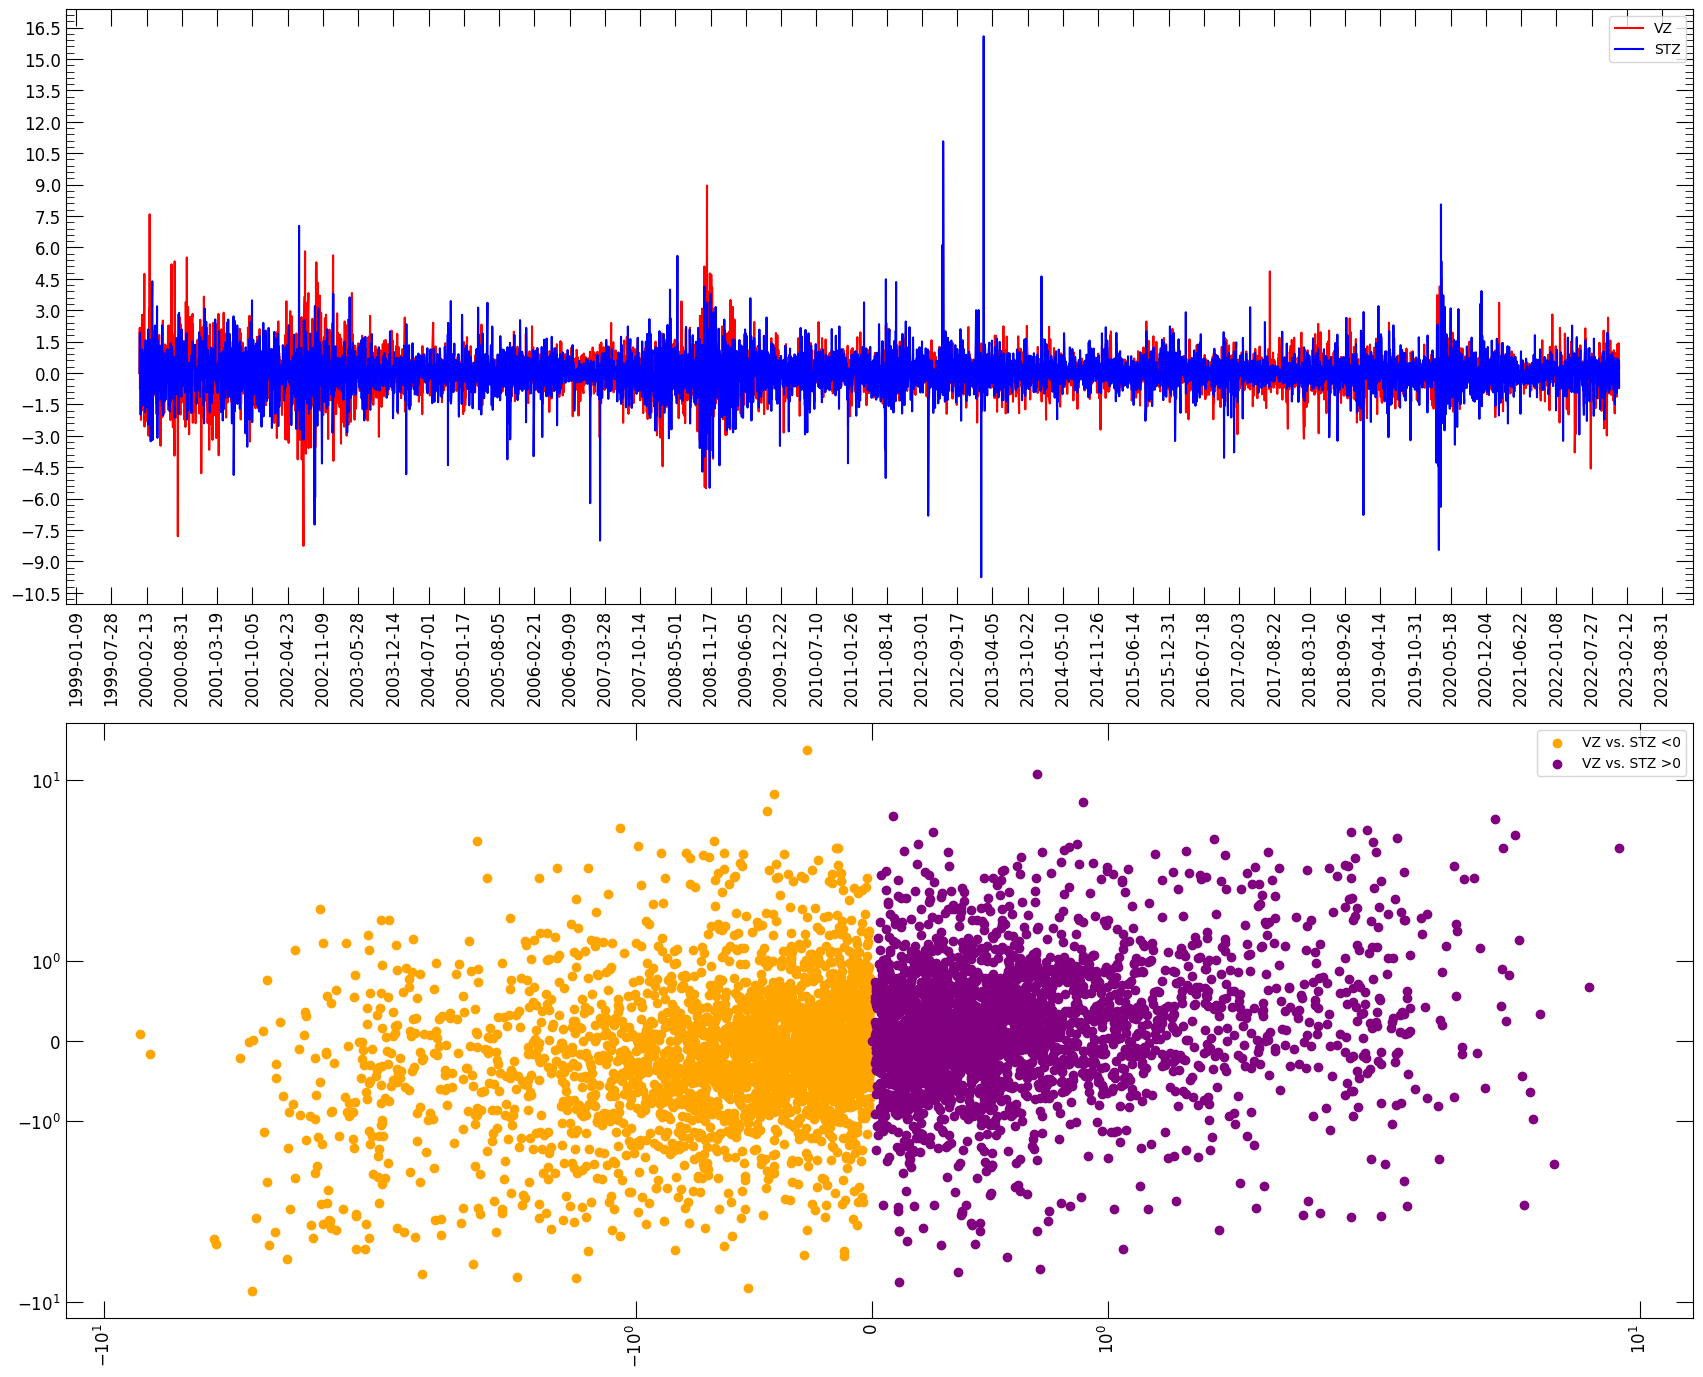

In [11]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

s1 = "VZ"
s2 = "STZ"

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == s1]
df_2 = df_stock_index[df_stock_index["symbol"] == s2]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin([s1, s2])]
        .pivot(index = "date", columns = "symbol", values = "normalized_log_return")
        .reset_index()
)
df_3["temp_1"] = df_3[s1]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[s2]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[s1] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1["normalized_log_return"], color = "red", label = s1)
ax[0].plot(df_2["date"], df_2["normalized_log_return"], color = "blue", label = s2)
ax[1].scatter(df_3[df_3["mask"] == 0]["temp_1"], df_3[df_3["mask"] == 0]["temp_2"], color = "orange", label = "{} vs. {} <0".format(s1, s2))
ax[1].scatter(df_3[df_3["mask"] == 1]["temp_1"], df_3[df_3["mask"] == 1]["temp_2"], color = "purple", label = "{} vs. {} >0".format(s1, s2))
#ax[1].scatter(df_3[s1], df_3[s2], color = "orange", label = "{} vs. {}".format(s1, s2))

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
ax[1].set_xscale(value = "symlog")
ax[1].set_yscale(value = "symlog")

plt.show()


symbol       date  AIZ       IVZ  temp_1    temp_2  mask
0      2000-01-04  NaN  0.000000     NaN  0.000000     1
1      2000-01-05  NaN -1.497275     NaN -1.497275     1
2      2000-01-06  NaN -0.415131     NaN -0.415131     1
3      2000-01-07  NaN  1.275931     NaN  1.275931     1
4      2000-01-10  NaN -0.201265     NaN -0.201265     1


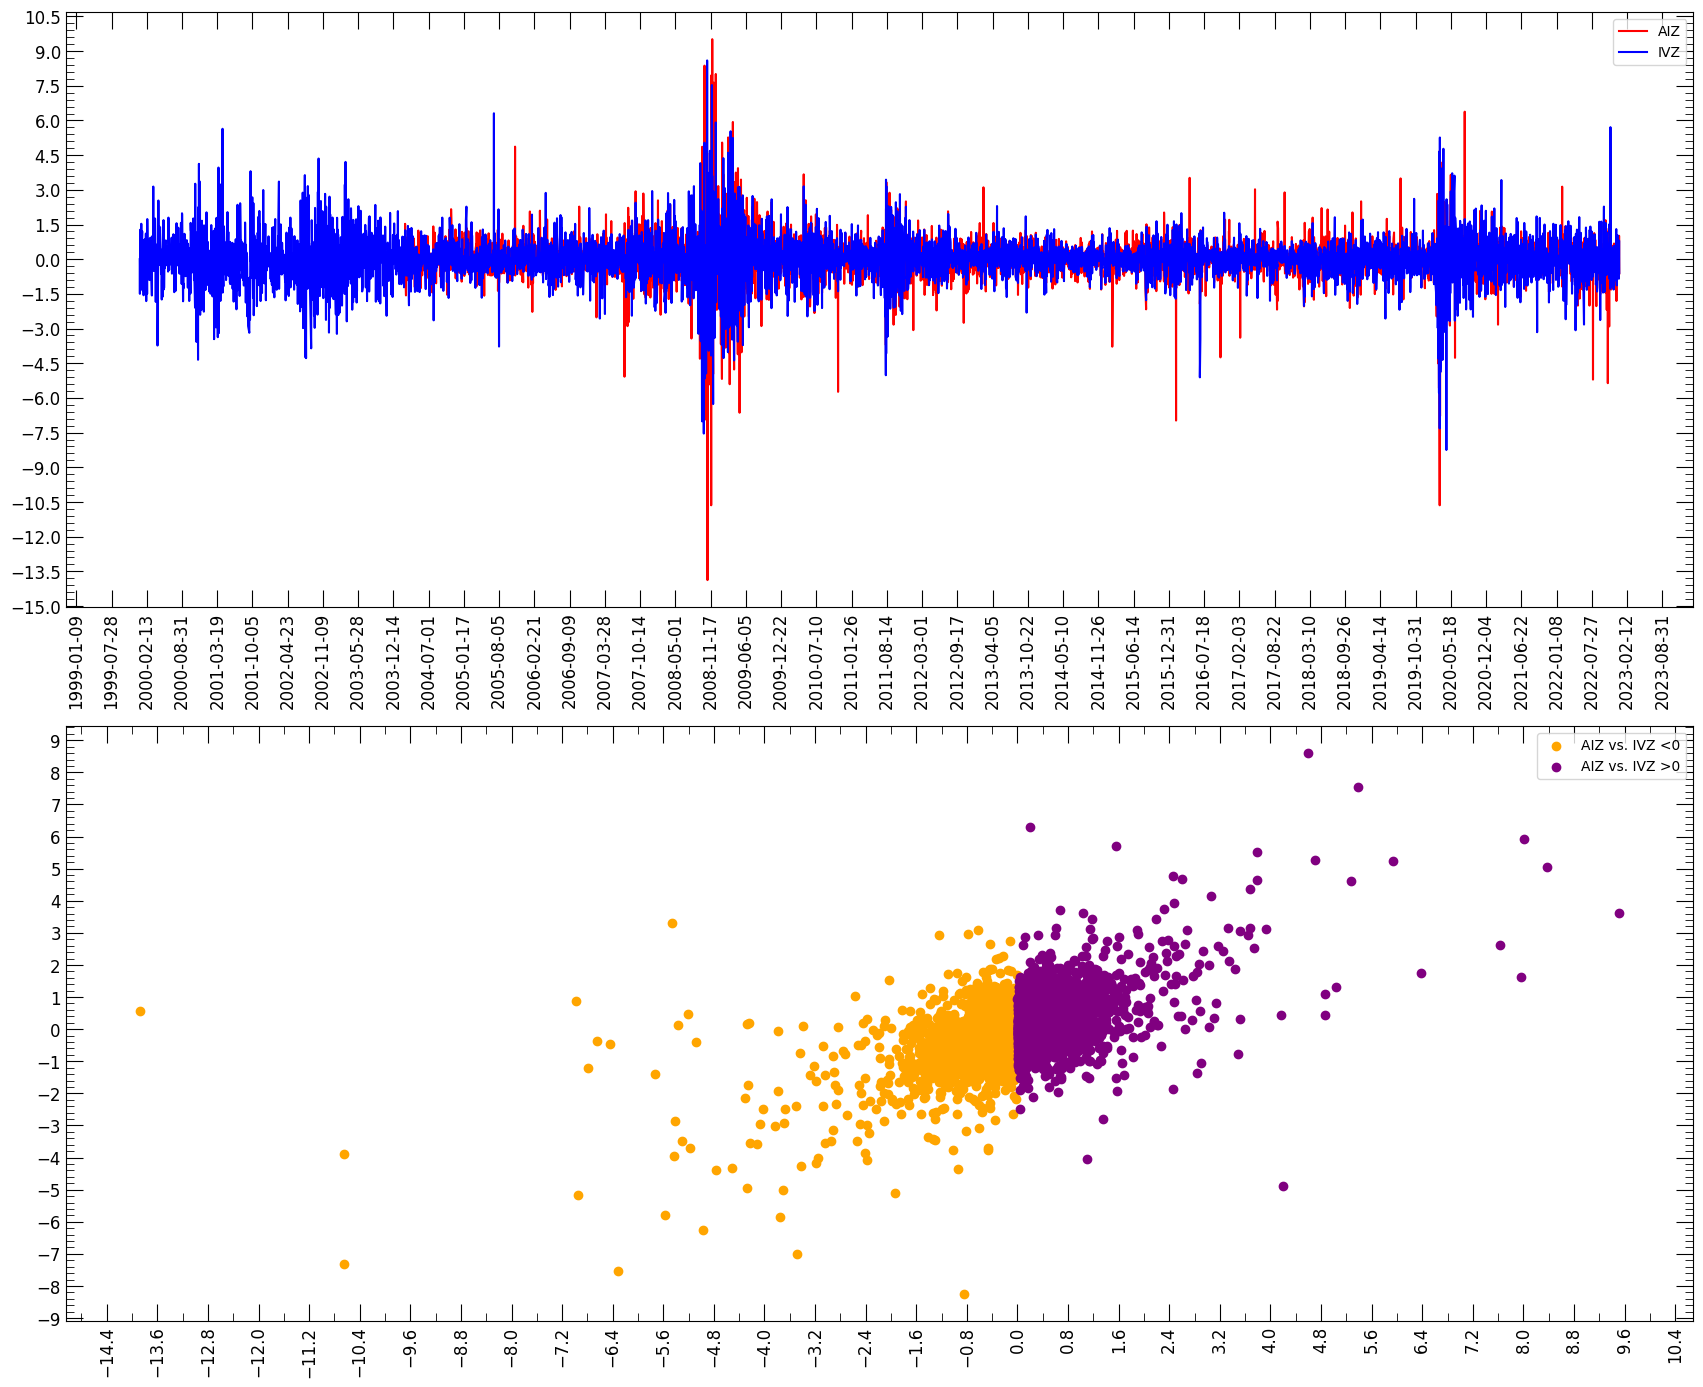

In [12]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

from scipy.optimize import curve_fit # type: ignore

def symlog(x):
    if x >= 0:
        return np.log(x)
    else:
        return -np.log(-x)

s1 = "AIZ"
s2 = "IVZ"

fig,ax = plt.subplots(2,1)
fig.set_size_inches(w = 21, h = 17)

df_1 = df_stock_index[df_stock_index["symbol"] == s1]
df_2 = df_stock_index[df_stock_index["symbol"] == s2]
df_3 = (
    df_stock_index[df_stock_index["symbol"].isin([s1, s2])]
        .pivot(index = "date", columns = "symbol", values = "normalized_log_return")
        .reset_index()
)
df_3["temp_1"] = df_3[s1]#.apply(lambda x: symlog(x))
df_3["temp_2"] = df_3[s2]#.apply(lambda x: symlog(x))
df_3["mask"] = 1
df_3["mask"] = df_3["mask"].mask(cond = df_3[s1] < 0, other = 0)
#df_3 = df_3[((df_3[s1] <= df_3[s1].quantile(0.95)) & (df_3[s2] <= df_3[s2].quantile(0.95)) & (df_3[s1] >= df_3[s1].quantile(0.05)) & (df_3[s2] >= df_3[s2].quantile(0.05)))]
print(df_3.head())

ax[0].plot(df_1["date"], df_1["normalized_log_return"], color = "red", label = s1)
ax[0].plot(df_2["date"], df_2["normalized_log_return"], color = "blue", label = s2)
ax[1].scatter(df_3[df_3["mask"] == 0]["temp_1"], df_3[df_3["mask"] == 0]["temp_2"], color = "orange", label = "{} vs. {} <0".format(s1, s2))
ax[1].scatter(df_3[df_3["mask"] == 1]["temp_1"], df_3[df_3["mask"] == 1]["temp_2"], color = "purple", label = "{} vs. {} >0".format(s1, s2))
#ax[1].scatter(df_3[s1], df_3[s2], color = "orange", label = "{} vs. {}".format(s1, s2))

ax[0].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[0].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[0].xaxis.set_major_locator(mtick.MaxNLocator(60))
ax[0].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[0].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[0].tick_params(axis = "x", labelrotation = 90)
ax[0].legend()

ax[1].tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax[1].tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax[1].xaxis.set_major_locator(mtick.MaxNLocator(40))
ax[1].xaxis.set_minor_locator(mtick.MaxNLocator(4 * 20))
ax[1].yaxis.set_major_locator(mtick.MaxNLocator(20))
ax[1].yaxis.set_minor_locator(mtick.MaxNLocator(5 * 20))
ax[1].tick_params(axis = "x", labelrotation = 90)
ax[1].legend()
#ax[1].set_xscale(value = "symlog")
#ax[1].set_yscale(value = "symlog")

plt.show()


## Compare spectrum

In [13]:
from scipy.linalg import eigh # type: ignore

df_1 = A[A.symbol]
df_2 = (
    df_entropy[["symbol_x", "symbol_y", "modified_jaccard_distance"]]
        .drop_duplicates()
        .pivot(index = "symbol_x", columns = "symbol_y", values = "modified_jaccard_distance")
)

df_3 = pd.DataFrame({
        "eige_corr" : eigh(df_1)[0],
        "eigenvalues_entropy" : eigh(df_2)[0]
    }
).value_counts(dropna = False, sort = True).reset_index()

df_3

,eige_corr,eigenvalues_entropy,count
0,0.426674,-0.007235,1
1,0.442496,0.013346,1
2,0.524403,0.020277,1
3,0.630548,0.024408,1
4,0.651991,0.028497,1
5,0.686435,0.038860,1
6,0.732875,0.043288,1
7,0.787384,0.045755,1
8,0.821051,0.061142,1
9,0.926460,0.109174,1


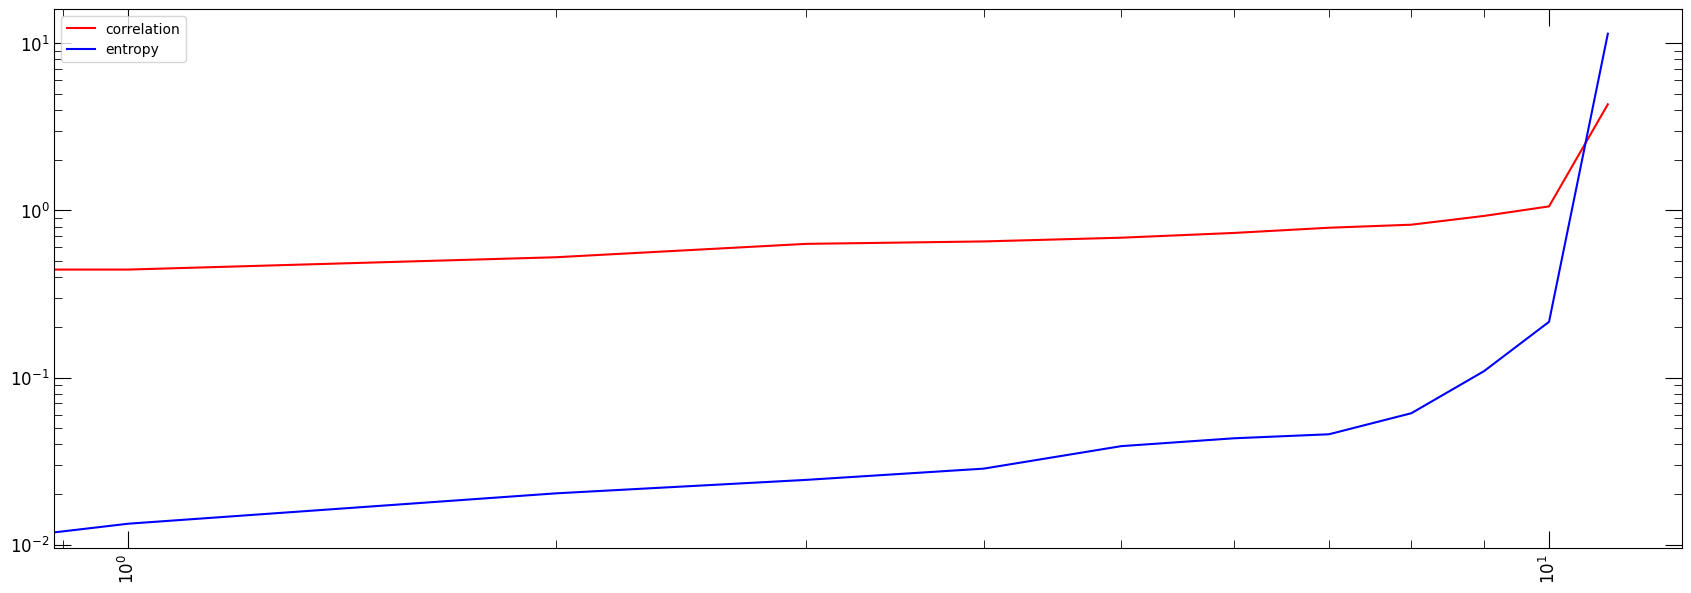

In [23]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.ticker as mtick # type: ignore

fig,ax = plt.subplots()
fig.set_size_inches(w = 21, h = 7)

df_4 = df_3#.head(10)

ax.plot(df_4["eige_corr"], color = "red", label = "correlation")
ax.plot(df_4["eigenvalues_entropy"], color = "blue", label = "entropy")

ax.tick_params(which = "major", direction = "in", top = True, right = True, labelsize = 12, length = 12)
ax.tick_params(which = "minor", direction = "in", top = True, right = True, labelsize = 12, length = 6)
ax.tick_params(axis = "x", labelrotation = 90)
ax.legend()

ax.set_xscale(value = "log")
ax.set_yscale(value = "log")

plt.show()
